# Example exercise

## Run the Cell Below Before Preforming the Excersizes
This cell creates a Neo4j graph database from a SQL query. You do not need to understand how it works right now, but you are welcome to look through this code if you are intrested. 

In [2]:
# Imports 
import sys
from py2neo import neo4j, Graph, Relationship
from py2neo.cypher import CypherWriter
import MySQLdb

print "Clear Imports"
# Create MySQL connection
user = "lcdebaca"
password = "qbRUy*uW7bUffBcBUBD7"
database = "starmetrics"

# invoke the connect() function, passing parameters in variables.
db = MySQLdb.connect( user = user, passwd = password, db = database )

# output basic database connection info.
print( db )

cursor = db.cursor( MySQLdb.cursors.DictCursor )
# Print Curser
print(cursor)

print "Clear Database Connection"

# Collecting data from SQL 

# The Following is a Query of the starmetrics database
# It collects the following variables for Purdue University between the 
#years 2008 - 2012:  
#From the employee Table: id, employeeid, uniqueawardnumber, employeeoccupation
#From the occupation Table: occupationalclassification 

# NOTE I LIMIT TO 200 BECAUSE THE REST OF THE NOTEBOOK WONT RUN OTHERWISE 
sql_select = "SElECT employee.employeeid, employee.uniqueawardnumber, employee.occupation_orig, \
occupation.occupationalclassification \
FROM starmetrics.employee \
INNER JOIN starmetrics.occupation ON \
starmetrics.employee.occupation_orig = occupation.occupation_orig \
WHERE starmetrics.employee.university = 'purdue' AND starmetrics.employee.year BETWEEN 2008 AND 2012 LIMIT 200;"

result_count = cursor.execute(sql_select);

# Count the number of rows returned 
print("Found " + str(result_count) + " rows")

# Store the results of the Query in a list
results = cursor.fetchall()

print "Clear SQL Query"

# Create connection to the Neo4jsdatabase using defaults
# note, I imported Graph when I imported py2neo
graph_db = Graph()
print graph_db

# Create The Neo4j Database 
graph_db.create()

#Jsut to make sure the new database is empty, this code will delete all exsiting nodes and relationships 
graph_db.delete_all()

# Force nodes to have unique employeeids and uniqueawardnumber
#graph_db.schema.create_uniqueness_constraint("employeeid", "uniqueawardnumber")

print "Clear Create Neo DB"

# Above I saved the results of the SQL Query into a list called results
# Below I iterate over that list, create properties based on the varibles in the SQL database,
# and finaly create an 'employee' node with those properties

for employee in results:
    id_num = employee['employeeid']
    occ_orig = employee['occupation_orig']
    occ_class = employee['occupationalclassification']
    award_num = employee['uniqueawardnumber']
    # Wee tiny bit of data cleaning
    if award_num[0] == "'":
        award_num = award_num[1:len(award_num)]

    # Create a node with above infomation (This node is not in the Graph yet though)
    new_employee_node = neo4j.Node("Employee", employeeid = id_num, occcupation_orig = occ_orig, \
                      occupationalclassification = occ_class)
    new_award_node = neo4j.Node("Award", uniqueawardnumber = award_num)
    
    new_employee = False
    new_award    = False
    # Check to see that the employee is not already in the graph 
    if graph_db.find_one("Employee", "employeeid", id_num) == None:
        new_employee = True
        graph_db.create( new_employee_node )
    
        
    
    # Check to see that the award is not already in the graph 
    if graph_db.find_one("Award", "uniqueawardnumber", award_num) == None:
        new_award = True
        graph_db.create( new_award_node )
   
    # Add relationships between the employees and the awards 
    # if noth bothe employee and the award are new, create a realtionship between them
    if (new_employee & new_award):
        new_relationship = Relationship(new_employee_node, "worked_on", new_award_node)
        graph_db.create( new_relationship )
    # if jus t he employee is new, then the award must already exisit 
    elif (new_employee):
        # find the exsisting award node 
        exsitsting_award_node = graph_db.find_one("Award", "uniqueawardnumber", award_num)
        # Create realtionship between that node and the new employee
        new_relationship = Relationship(new_employee_node, "worked_on", exsitsting_award_node)
        graph_db.create( new_relationship )
    
print "Clear Population"

# When looking at Employees and Awards, each Award has one to many Employees. So the quickest way to find a group of 
#employees that worked together is to find individual awards 

# for this we will use a straingt cypher command 
# Note, these cypher commands return RecordList Objects, Not Lists 

# Notice that we are asking Cypher to return n.uniqueawardnumber AS uniqueawardnumber
# doingthis will allow us to access this attribute as:  print awards_record[1].uniqueawardnumber
awards_record = graph_db.cypher.execute("MATCH (n:Award) RETURN n, n.uniqueawardnumber AS uniqueawardnumber;")

# Get length of Record 
awards_record_len = graph_db.cypher.execute("MATCH (n:Award) RETURN COUNT(*) AS count")

# Get the number of returned nodes as a number 
awards_record_len = awards_record_len[0].count

# The Cypher returned a RecordList Object, but a list would be easiest to work with;

"""
The following loop wil add every award number to a list ( I don't need the whole object to find the
employees who worked on that award )

Note, I find while loops work better for this work than for loops 
"""
count = 0
awards = []
while count < awards_record_len:
    awards.append(str(awards_record[count].uniqueawardnumber))
    count += 1 
    
print "Clear Employee Relatiponships Part 1" 

# Next we want to get a list of employees that worked on each of those awards 

# for every award in our award list; 
count = 0 
while count < len(awards):
    # Create a Cypher Query that collects the employees that have "worked_on" that award;
    tx = graph_db.cypher.begin()
    statment = "MATCH (n)-[r:worked_on]->(m {uniqueawardnumber:{NUM}}) RETURN n.employeeid AS employeeid;"
    # This bit of code subsitutes NUM for the award number contained in out awards list 
    tx.append(statment, {"NUM": awards[count]})
    relivent_employees_record = tx.commit()
    
    # Create a Query that collects the number employees that have "worked_on" that award;
    tx = graph_db.cypher.begin()
    statment = "MATCH (n)-[r:worked_on]->(m {uniqueawardnumber:{NUM}}) RETURN Count(*) AS count;"
    tx.append(statment, {"NUM": awards[count]})
    relivent_employees_record_len = tx.commit()
    
    # Get the number of returned nodes as a number (Cuz remember, the cypher Returns a RecordList)
    relivent_employees_record_len = relivent_employees_record_len[0][0].count
    
    #print relivent_employees_record
    #print relivent_employees_record[0][0].employeeid

    
    #I want emplyees in a list, not a Record Object, 
    i = 0
    relivent_employees = []
    while i < relivent_employees_record_len:
        relivent_employees.append(str(relivent_employees_record[0][i].employeeid))
        i += 1
    
    # Next create Relatioships between the employees'
    """
    What I'm doing here is saying connect the first employee with each employee that follows it in the list,
    then repete the process with the next employee until you reach the end of the list 
    
    There is a bug in the logic here
    """
    current_employee = 0 
    while current_employee < len(relivent_employees):
        next_employee = current_employee + 1 
        while next_employee < len(relivent_employees):
            tx = graph_db.cypher.begin()
            statment = "MATCH (n {employeeid: {NUM1}}), (m {employeeid: {NUM2}}) \
            CREATE (n)-[r:worked_with]->(m) RETURN r;"  
            tx.append(statment, {"NUM1": relivent_employees[current_employee], "NUM2": relivent_employees[next_employee]})
            tx.commit()
            next_employee += 1 
        current_employee += 1
    

    #DONT COMMENT THIS OUT REN
    count += 1
print "Clear Employee Relatiponships Part 2" 

print "Neo4j Database Loaded"

Clear Imports
<_mysql.connection open to 'localhost' at 2de7970>
Clear Database Connection
Found 200 rows
Clear SQL Query
<Graph uri=u'http://localhost:7474/db/data/'>
Clear Create Neo DB
Clear Population
Clear Employee Relatiponships Part 1
Clear Employee Relatiponships Part 2
Neo4j Database Loaded


#### The cell below is intended for you to test Cypher Queries

In [180]:
graph_db.cypher.execute("MATCH (n {employeeid:'704'}) -[r:worked_with] -> (b) RETURN b;") 

   | b                                                                                                                   
---+----------------------------------------------------------------------------------------------------------------------
 1 | (n271401:Employee {employeeid:"90023086",occcupation_orig:"FACULTY",occupationalclassification:"Faculty"})          
 2 | (n271403:Employee {employeeid:"90002600",occcupation_orig:"GRADUATE",occupationalclassification:"Graduate Student"})
 3 | (n271404:Employee {employeeid:"12363",occcupation_orig:"UNDERGRAD",occupationalclassification:"Undergraduate"})     

# Introduction to Neo4j and Cypher
## What is a Graph Database?

 When you think of data, you probably imagine an excel table where each row is an individual observation or data point. 
For example, 

|name | age | employee_id|
|-----|-----|------------|
|Joe  |  34 |   12345    |
|Ann  |  54 |   12346    |
    
In a graph database, that row is more like a ball. 


##### (node: Employee {name:Joe, age: 34, employee_id: 12345})

This ball is called a "node" in Neo4j. In fact, the little parentheses around Joe's information are designed to help the user think of Joe's information as a little ball. 

All the information about Joe is still there, but it's just not in a flat table format. Instead of storing each peice of Joe's information in a variable column, Joe's information is stored as **properties**, ie name, age, employee_id.
Joe's node also has a **label**, *Employee*, to identify this node as belonging to an employee.


Neo4j uses the Cypher Query Language to get information out of the Database. 

##### Components of a simple Cypher Query:
+ MATCH      
     - Essentially the same thing as SELECT in SQL 
+ (n)        
    - Any node (the n is just a variable, could be any letter) 
+ RETURN     
    - Needed in every query 
+ LIMIT      
    - Same as in SQL 

The following query will return 20 nodes from the database:  
##### graph_db.cypher.execute("MATCH (n) RETURN n LIMIT 20")

If you look at the results, you might notice the some nodes have n0000:Employee and other have n0000:Award.
This is because some of the nodes describe the data of an employee and thus have the Employee label while others describe awards and are thus labels appropriately 

If I wanted to query just Award nodes, I would run this query;  
##### graph_db.cypher.execute("MATCH (n:Award) RETURN n LIMIT 20")


## Part A (X points) - Cypher Query language

 Write a Query that returns 10 Employee nodes

In [181]:
graph.cypher.execute("MATCH (n:Employee) RETURN n LIMIT 10")

NameError: name 'graph' is not defined

In [ ]:
"""
Your query should return a RecordList of employee nodes like the following one. 
(Note, this is not a python list, it is a RecordList object)  

    | n                                                                                                                   
----+----------------------------------------------------------------------------------------------------------------------
  1 | (n269757:Employee {employeeid:"90009387",occcupation_orig:"UNDERGRAD",occupationalclassification:"Undergraduate"})  
  2 | (n269759:Employee {employeeid:"90027173",occcupation_orig:"GRADUATE",occupationalclassification:"Graduate Student"})
  3 | (n269761:Employee {employeeid:"90014540",occcupation_orig:"FACULTY",occupationalclassification:"Faculty"})          
  4 | (n269762:Employee {employeeid:"90022062",occcupation_orig:"GRADUATE",occupationalclassification:"Graduate Student"})
  5 | (n269763:Employee {employeeid:"90003312",occcupation_orig:"GRADUATE",occupationalclassification:"Graduate Student"})
  6 | (n269764:Employee {employeeid:"90026679",occcupation_orig:"FACULTY",occupationalclassification:"Faculty"})          
  7 | (n269766:Employee {employeeid:"90017693",occcupation_orig:"FACULTY",occupationalclassification:"Faculty"})          
  8 | (n269767:Employee {employeeid:"90028696",occcupation_orig:"FACULTY",occupationalclassification:"Faculty"})          
  9 | (n269769:Employee {employeeid:"90013819",occcupation_orig:"FACULTY",occupationalclassification:"Faculty"})          
 10 | (n269771:Employee {employeeid:"15226",occcupation_orig:"GRADUATE",occupationalclassification:"Graduate Student"}) 
 
 """

What makes graph databases like Neo4j special is the ability to create relationships between nodes:

For instance, the database has two types of relationships; worked_on and worked_with.  
 + Employees have a *worked_on* relationship with nodes which represent awards on which the employee has worked.   
 + Employees have a *worked_with* relationship with nodes that represent employees that worked on the same award

To view what this looks like, this query will return 5 instances of the pattern where an employee worked_on an award, and return the relationship. 

#### graph_db.cypher.execute("MATCH (e)-[r:worked_on]->(a) RETURN  r LIMIT 5;")

If you look at this query you kinda see a pattern of (node1) -[relationship]-> (node2). You can imagine that this is one ball with an arrow pointing to another ball. Each ball is a node of data and the arrow is a relationship.  What this query is asking the the database to do is go through all the nodes and relationships and find the pattern where one node has a realtionship pointing to another node and that realtionship has the label "worked_on".  


Write a Query that returns 15 instances of employees that worked on the same grant. Return both employee nodes

In [ ]:
graph_db.cypher.execute("MATCH (a)-[r:worked_with]->(b) RETURN a, b LIMIT 15;") 

In [ ]:
"""
Your query should return a RecordList of employee nodes. (Note, this is not a python list, it is a RecordList object)  

    | a                    | b                   
----+----------------------+----------------------
  1 | (n269825:`90003312`) | (n269826:`90022062`)
  2 | (n269827:`90003312`) | (n269828:`90014540`)
  3 | (n269829:`90003312`) | (n269830:`90027173`)
  4 | (n269831:`90022062`) | (n269832:`90014540`)
  5 | (n269833:`90022062`) | (n269834:`90027173`)
  6 | (n269835:`90014540`) | (n269836:`90027173`)
  7 | (n269837:`90017693`) | (n269838:`90026679`)
  8 | (n269839:`2623`)     | (n269840:`15226`)   
  9 | (n269841:`2623`)     | (n269842:`90013819`)
 10 | (n269843:`15226`)    | (n269844:`90013819`)
 11 | (n269845:`90026924`) | (n269846:`10622`)   
 12 | (n269847:`90026924`) | (n269848:`90001300`)
 13 | (n269849:`90026924`) | (n269850:`90003242`)
 14 | (n269851:`90026924`) | (n269852:`90007913`)
 15 | (n269853:`10622`)    | (n269854:`90001300`)

"""

https://www.wakari.io/sharing/bundle/nvikram/Basics%20of%20Networkx?has_login=False
http://patrick-fuller.com/igraph/examples/ipython.html

## Neo4j and Networkx 

This would all be so much cooler if you could see the data, right?

But first, we have to convert our neo4j database into a networks objects 
Pulling data from a cypher query into networkx objects with example

In [4]:
def recordlist_to_list(recordlist, record_property, len_of_recordlist = 1):
    """
    Used to convert the result of a cypher query into a python list. 
    The Cypher Query should return a single property of the node as an alias, ie 
    graph_db.cypher.execute("MATCH (n) RETURN n.record_property AS record_property  
    
    Parameters
    --------------------------------
    recordlist: A RecordList object returned by a Cypher.execute command 
    record_property: The property that was returned by the Cypher.execute command as an alias 
    len_of_recordlist: the number of nodes returned by the Cypher.execute command. Defaluted to 1
    """
    
    count = 0
    final_list = []
    while count < len_of_recordlist:
        command = "recordlist[" + str(count) + "][0]" +"['" + record_property +"']"      
        final_list.append( eval(command))
        count += 1 
    return final_list


In [7]:
## Collect a collection of nodes to display
# maybe i'll make this a subgraph later '

# Get a award node (I picked a random Award number to seach for)
# Notice that this Query return only the award number
specific_award_node = graph_db.cypher.execute("MATCH (m {uniqueawardnumber:'00.070 03-C-NE-PU'}) RETURN m;")

# Collect all the employees that worked on that award
# Notice that this Query return only the employee id number 
associated_employees = graph_db.cypher.execute("MATCH (n:Employee) -[r:worked_on]->(a {uniqueawardnumber:'00.070 03-C-NE-PU'}) RETURN n;") 

# Count number of employees that worked on that Awars ( this will be used below )
num_associtated_employees = graph_db.cypher.execute("MATCH (n:Employee) -[r:worked_on]->(a {uniqueawardnumber:'00.070 03-C-NE-PU'}) RETURN COUNT(n);") 

# Remember, all the queries above return RecordList objects, which is a little awkward to deal with. So i'm going to use 
# the function I created, record_to_list(),to convert the infomation I want into a python list 

# First, I convert the award node ( Note, because the award numbers are unique, I know there are only one of these)
specific_award_node = recordlist_to_list(specific_award_node, 'uniqueawardnumber')

# Next , I  need the number of Employees who worked on that project 
num_associtated_employees = graph_db.cypher.execute("MATCH (n:Employee) -[r:worked_on]->\
(a {uniqueawardnumber:'00.070 03-C-NE-PU'}) RETURN n;").to_subgraph().order


# Finally, I use the number of employees who worked on that node 
associated_employees = recordlist_to_list(associated_employees, "employeeid", num_associtated_employees)


#print award node
for item in specific_award_node:
    print item

#print associated_employees
for item in associated_employees:
    print item
    
############################################
#NOTE, in order to get the number of nodes returned by the, 
# graph_db.cypher.execute("MATCH (n:Employee) -[r:worked_on]->(a {uniqueawardnumber:'00.070 03-C-NE-PU'}) RETURN n.employeeid AS employeeid;") 
#Command I could call .to_subgraph on it 
# This will convert that reselt into a subgraph
# then calling .order will return the number of nodes in that result 
# But make sure recordlist_list still recives and recordlist as a parameter otherwise we wont get our infomation


00.070 03-C-NE-PU
90003312
90022062
90014540
90027173


At this point we have two lists 

+ specific_award_node is a list of length one that contains the award number of a particular award 
+ associated_employees is a list of length four that contains the employees that worked on that node 

Now lets create some Networkx objects from these list a display a plot of what this looks like 

[u'00.070 03-C-NE-PU', None, u'90022062', u'90003312', u'90027173', u'90014540']


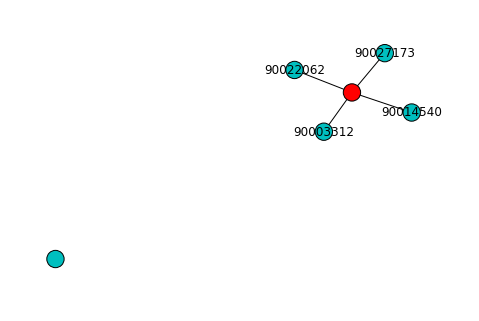

In [8]:
# Creating Networks Objects 

#Imports that should really be at the top of the notebook 
import networkx as nx
# Allows plots to be showed inline 
%matplotlib inline
# Matplotlib is the default package for
# rendering the graphs
import matplotlib.pyplot as plt

# Create the Networkx Graph 
G=nx.Graph()

# Distonarys to contain colors and labels
# Not nessasary
custom_node_color = {}
custom_labels     = {}

#Create the networkx award node 
award_node = G.add_node(specific_award_node[0])
custom_node_color[specific_award_node[0]] = 'r'

#Create networkx nodes for the employees that worked on that node 
for item in associated_employees:
    G.add_node(item)
    custom_node_color[item] = 'c'
    custom_labels[item] = str(item)
    # We know at each of these employees are connected to the award, so lets draw those relationshipd 
    # Note, in Networkx relationships are called edges 
    G.add_edge(item, award_node)
    

print G.nodes()
nx.draw(G,labels=custom_labels, node_color=custom_node_color.values())
plt.show()


# Idk why we always get a bonus None node, i like to thnk of it as a gift 

 We just created aplot of all the employees worked on an award
 
 Employees also have realtionhsips with each other, the employees that worked with them
 

### Write a function that accepts  a Cypher Query, and returns a networkx graph. Also, have your function plot the graph 

Hint: graph_db.cypher.execute("MATCH (n {employeeid:'704'}) -[r:worked_with] -> (b) RETURN b;") 

<Subgraph order=3 size=0>
[u'90023086', u'90002600', u'12363']
['Orinianl Employee', u'12363', u'90002600', u'90023086', None]


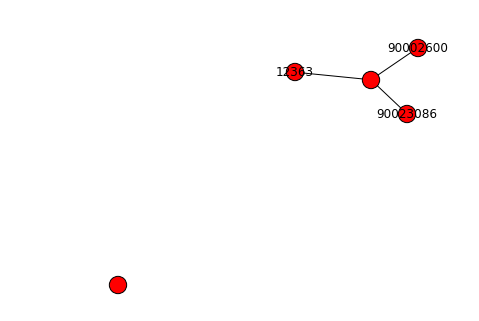

In [17]:
def employee_peers():
    """
    
    """
    # Collect Employees that worked with that Employee 
    
    peer_employees = graph_db.cypher.execute("MATCH (n {employeeid:'704'}) -[r:worked_with] -> (b) RETURN b;")
    subgraph = graph_db.cypher.execute("MATCH (n {employeeid:'704'}) -[r:worked_with] -> (b) RETURN b;").to_subgraph()
    num_peer_employees = peer_employees.to_subgraph().order
    print subgraph
    
    # Convert that RecordList to a list object 
    peer_employees = recordlist_to_list(peer_employees, "employeeid", num_peer_employees)
    print peer_employees
    
    # Create the Networkx Graph 
    G=nx.Graph()
    
    # Distonarys to contain and labels
    custom_labels     = {}
    
    # I know that there is one employee that is the connector between all these other employees, 
    # so ill create a dummby node to represent them
    origin_employee = G.add_node("Orinianl Employee")
    
    # Create that employee's peers 
    for employee in peer_employees:
        G.add_node(employee)
        custom_labels[employee] = str(employee)
        # We know this employee worked with the origin emplyee, so lets connect them 
        G.add_edge(employee, origin_employee)

        
    # Draw and Display the Plot 
    print G.nodes()
    nx.draw(G, labels=custom_labels)
    plt.show()
    
    Return the Graph Object 
    return G 
        
        
employee_peers()

## Anaylsing Networks 

In [189]:
graph_db.cypher.execute("MATCH (n {employeeid:'704'}) -[r:worked_with] -> (b) RETURN b.employeeid AS employeeid;").to_subgraph()

<Subgraph order=0 size=0>